# Clustering Yelp Restaurants Part 1

In this project, I have worked with the [Yelp dataset](https://www.yelp.com/dataset/challenge). Download the data from Round 10. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

# Solution Starts Here:

I have parsed the json data object by object and created a dataframe with 3 columns - latitude, longitude, and categories. I pick out the top 20 categories that occur in the data and remove the rest from all the objects. Then I use CountVectorizer to vectorize the categories for all the objects and create a new dataframe for this data. I scale the latitude and longitude and join it with the new dataframe. This dataframe is then passed to the clustering functions to get the clusters. I have selected 5 clusteres based on the error and silhouette coefficients. You can see that 3 and 5 have the highest silhouette coefficients but since 5 has a lower error rate, I went with 5.

In [284]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.manifold import MDS
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import fcluster,dendrogram, linkage, cophenet
from sklearn import mixture
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [285]:
data = []
categories = []
restaurantCategoriesList = []
columns = ['Latitude', 'Longitude', 'Categories']
for obj in open('business.json'):
    attr = []
    ob = json.loads(obj)
    blah = dict(ob.items())
    if (blah['city'] == 'Las Vegas')&('Restaurants' in blah['categories']):
        attr.append(blah['latitude'])
        attr.append(blah['longitude'])
        attr.append(', '.join(blah['categories']))
        restaurantCategoriesList.append(blah['categories'])
        for i in blah['categories']:
            if i not in ['Restaurants', 'Food', 'Fast Food', 'Nightlife']:
                categories.append(i)
        data.append(attr)
df = pd.DataFrame(data, columns=columns)        
df.head()

,Latitude,Longitude,Categories
0,36.196203,-115.116799,"Restaurants, American (Traditional), Mexican, ..."
1,36.112519,-115.242605,"Mexican, Restaurants"
2,36.083384,-115.033995,"Chinese, Food, Convenience Stores, Restaurants"
3,36.159363,-115.135949,"Seafood, Restaurants, Specialty Food, Ethnic F..."
4,36.012191,-115.173993,"Food, Restaurants, Mexican"


In [286]:
df_categories = pd.DataFrame(categories, columns=['category'])
df_categories['count'] = df_categories.groupby('category')['category'].transform('count')
df_categories = df_categories.drop_duplicates().reset_index(drop=True)
df_categories = df_categories.sort_values('count', ascending=False).reset_index(drop=True)
df_categories = df_categories[:20]
df_categories['category'] = df_categories['category'].str.replace(' ', '_')
df_categories['category'] = df_categories['category'].str.replace('(', '')
df_categories['category'] = df_categories['category'].str.replace(')', '')
df_categories['category'] = df_categories['category'].str.replace('&_', '')
df_categories

,category,count
0,American_Traditional,739
1,Mexican,724
2,Bars,720
3,Sandwiches,621
4,Pizza,587
5,American_New,555
6,Burgers,505
7,Chinese,410
8,Breakfast_Brunch,390
9,Italian,370


In [287]:
restaurantTopCategoriesList = []
for i in restaurantCategoriesList:
    newList = []
    for j in i:
        j = j.replace(' ', '_')
        j = j.replace(')', '')
        j = j.replace('(', '')
        j = j.replace('&_', '')
        if j in df_categories['category'].tolist():
            newList.append(j)
    restaurantTopCategoriesList.append(newList)

restaurantTopCategoriesListToVetorize = []
for i in restaurantTopCategoriesList:
    restaurantTopCategoriesListToVetorize.append(', '.join(i))
restaurantTopCategoriesListToVetorize

['American_Traditional, Mexican',
 'Mexican',
 'Chinese',
 'Seafood, Mexican',
 'Mexican',
 '',
 'Chicken_Wings, American_New',
 'Barbeque',
 'Mexican',
 'Burgers, Bars, American_Traditional',
 'Chicken_Wings',
 '',
 '',
 'Asian_Fusion, Japanese, Seafood',
 'American_Traditional, Burgers',
 'American_New, Desserts',
 'Breakfast_Brunch',
 'American_New',
 'Steakhouses',
 'American_Traditional, American_New, Pizza',
 'Mexican',
 'Pizza',
 'Japanese, Bars, Asian_Fusion',
 '',
 '',
 'Sandwiches, Breakfast_Brunch',
 'Sandwiches',
 'Sandwiches, American_Traditional',
 'Italian',
 'American_Traditional, Barbeque, Event_Planning_Services',
 '',
 '',
 'Mexican, Event_Planning_Services, Bars',
 'Mexican',
 'Asian_Fusion, Bars, Cafes',
 'Pizza, Italian',
 'Chinese',
 'Chinese',
 'American_New, Sandwiches',
 'Italian, Steakhouses, Seafood, American_Traditional, Mexican',
 'Italian, Seafood',
 'American_New, Sushi_Bars',
 'American_New, American_Traditional, Desserts',
 'Breakfast_Brunch, American_

In [288]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(restaurantTopCategoriesListToVetorize)
vectorsArray = vectors.toarray()
vectorsArray

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [289]:
df_final = pd.DataFrame(vectorsArray)
df_final[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']]
df_final['Latitude'] = (df_final['Latitude'] - df_final['Latitude'].mean())/df_final['Latitude'].std()
df_final['Longitude'] = (df_final['Longitude'] - df_final['Longitude'].mean())/df_final['Longitude'].std()
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,Latitude,Longitude
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1.155310,1.121126
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.300530,-0.749492
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,-0.807387,2.352334
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0.514411,0.836380
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-2.045937,0.270701


In [300]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

In [301]:
def sc_evaluate_clusters(df_final,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
        kmeans.fit_predict(df_final)
        s[k] = metrics.silhouette_score(df_final,kmeans.labels_,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')

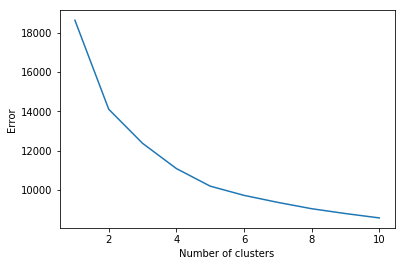

In [302]:
evaluate_clusters(df_final,10)

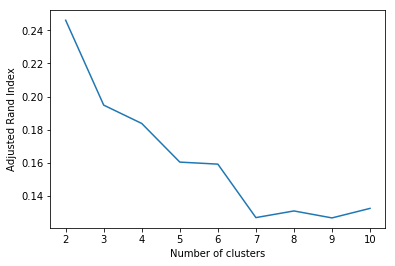

In [303]:
sc_evaluate_clusters(df_final,10)

In [294]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=100) 
km_clusters = kmeans.fit_predict(df_final)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
km_0 = np.where(km_clusters==0)
km_1 = np.where(km_clusters==1)
km_2 = np.where(km_clusters==2)
km_3 = np.where(km_clusters==3)
km_4 = np.where(km_clusters==4)
km_clusters_list = [km_0, km_1, km_2, km_3, km_4]

In [295]:
hc = linkage(df_final, method ='complete',metric = 'euclidean')
hc_cluster = fcluster(hc,5,criterion='distance')
hc_0 = np.where(hc_cluster==1)
hc_1 = np.where(hc_cluster==2)
hc_2 = np.where(hc_cluster==3)
hc_3 = np.where(hc_cluster==4)
hc_4 = np.where(hc_cluster==5)
hc_clusters_list = [hc_0, hc_1, hc_2, hc_3, hc_4]

In [296]:
gmm = mixture.GMM(n_components=5, covariance_type='spherical')
gmm.fit(df_final)
gaussian = gmm.predict(df_final)
mean = gmm.means_
covar = gmm.covars_
gmm_0 = np.where(gaussian==0)
gmm_1 = np.where(gaussian==1)
gmm_2 = np.where(gaussian==2)
gmm_3 = np.where(gaussian==3)
gmm_4 = np.where(gaussian==4)
gmm_clusters_list = [gmm_0, gmm_1, gmm_2, gmm_3, gmm_4]

c:\users\yash\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\yash\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\yash\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\yash\a

In [297]:
def find_categoryLabel(cluster):
    max_value = 0
    labelDict = {}
    for i in cluster[0]:
        for j in restaurantTopCategoriesList[int(i)]:
            if j not in labelDict:
                labelDict[j] = 1
            else:
                labelDict[j] += 1
    return max(labelDict.items(), key=operator.itemgetter(1))[0]
    

In [298]:
km_clusters_labels = []
hc_clusters_labels = []
gmm_clusters_labels = []
for i in km_clusters_list:
    km_clusters_labels.append(find_categoryLabel(i))
for i in hc_clusters_list:
    hc_clusters_labels.append(find_categoryLabel(i))
for i in gmm_clusters_list:
    gmm_clusters_labels.append(find_categoryLabel(i))
gmm_clusters_labels

['Bars', 'Mexican', 'Mexican', 'Sandwiches', 'American_Traditional']

Below are the plots with the labels. Labels have been assigned based the the max count of a particular category found in each cluster.

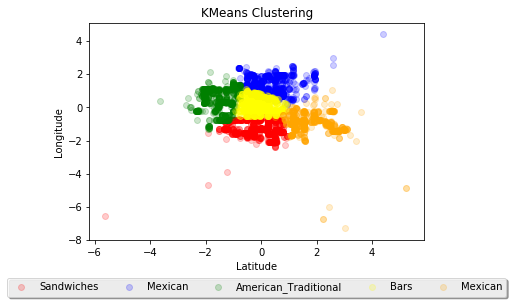

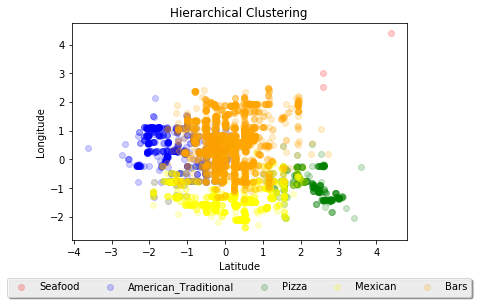

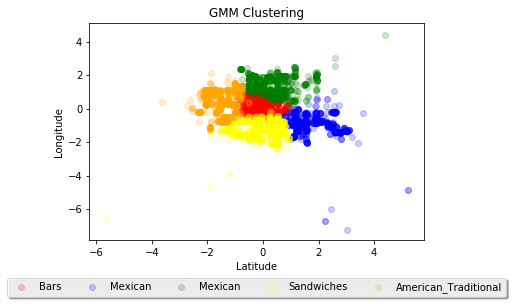

In [299]:
colors = ['red', 'blue', 'green', 'yellow', 'orange']

plt.figure(0)
p = 0
for i in km_clusters_list:
    for j in i:
        plt.scatter(df_final['Latitude'][j], df_final['Longitude'][j], color = colors[p], alpha=0.2)
        p += 1

plt.title('KMeans Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend([km_clusters_labels[i] for i in range(len(km_clusters_labels))],bbox_to_anchor=(0.5, -0.15), loc='upper center', fancybox = True, shadow = True, ncol=5)

plt.figure(1)
p = 0
for i in hc_clusters_list:
    for j in i:
        plt.scatter(df_final['Latitude'][j], df_final['Longitude'][j], color = colors[p], alpha=0.2)
        p += 1

plt.title('Hierarchical Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend([hc_clusters_labels[i] for i in range(len(hc_clusters_labels))],bbox_to_anchor=(0.5, -0.15), loc='upper center', fancybox = True, shadow = True, ncol=5)

plt.figure(2)
p = 0
for i in gmm_clusters_list:
    for j in i:
        plt.scatter(df_final['Latitude'][j], df_final['Longitude'][j], color = colors[p], alpha=0.2)
        p += 1

plt.title('GMM Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend([gmm_clusters_labels[i] for i in range(len(gmm_clusters_labels))],bbox_to_anchor=(0.5, -0.15), loc='upper center', fancybox = True, shadow = True, ncol=5)

plt.show()

In the above plots you can see that there are few points that are quite far from the clusters. These points pull the cluster centroids near farther away from where their actual position could be be not for these outliers.

There is some different observations that can be made for Hierarchical Clusters. Since I have used the 'complete' method for hierarchical clustering, the outliers are ignored. But you can see that the 'Seafood' cluster has only three points. These three points that could be marked as outliers, form their own cluster.

Kmeans:

Kmeans give the most definiative clustering because it uses hard clustering unlike the other two. Since we use kmeas++ , each points is selected based on the probability of it being a centroid. This helps in reducing error.

Hierarchical:

Hierarchical has the most different results. This is because of two reasons - 1. It uses soft clustering 2. it ignores outliers. Since each point in hierarchical is a cluster itself, a few points that can be called outliers in other methods, become part of a cluster.

GMM:

GMM yields similar results to kmeans but there is some difference beacuse it uses soft clustering instead of hard. We can see that there is label that is repeated in GMM, this is because of overlapping points in clusters.

----------